In [ ]:

!pip install torchmetrics
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from tqdm import tqdm
import math

# Load data
df = pd.read_csv("p1_emg.csv")



In [ ]:
df.columns

Index(['Unnamed: 0', 'time', 'emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6',
       'emg7', 'emg8', 'label'],
      dtype='object')

In [ ]:
mapg = {
    "Thumb Extension":0,"index Extension":1,"Middle Extension":2,"Ring Extension":3,
    "Pinky Extension":4,"Thumbs Up":5,"Right Angle":6,"Peace":7,"OK":8,"Horn":9,"Hang Loose":10,
    "Power Grip":11,"Hand Open":12,"Wrist Extension":13,"Wrist Flexion":14,
    "Ulnar deviation":15,"Radial Deviation":16
}

df = df[df['label'] != 'rest']
df['label'] = df['label'].map(mapg)

features = ['emg1', 'emg2', 'emg3', 'emg4', 'emg5', 'emg6',
       'emg7', 'emg8']
# mov_win = 200
# df[features] = df[features].rolling(
#     window=mov_win,
#     min_periods=1,
#     center=True
# ).mean()


# Normalize EMG features
# features = [col for col in df.columns if 'emg' in col]
# # Min-Max Scaling to [0, 1]
# min_vals = df[features].min()
# max_vals = df[features].max()
# df[features] = (df[features] - min_vals) / (max_vals - min_vals + 1e-8)


# Parameters
window_size = 200  # adjust based on your data
features = [col for col in df.columns if 'emg' in col]

# Create clean, non-overlapping windows with consistent labels
X = []
y = []

for i in range(0, len(df) - window_size + 1, window_size):
    window = df.iloc[i:i+window_size]
    label_set = window['label'].unique()
    if len(label_set) == 1:  # Only keep windows with a single label
        X.append(window[features].values.astype(np.float32))
        y.append(label_set[0])

X = np.array(X)
y = np.array(y)

# Dataset
class EMGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X)  # shape: (N, window, channels)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].permute(1, 0), self.y[idx]  # shape: (channels, window)

dataset = EMGDataset(X, y)

In [ ]:


# Split data
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)



In [ ]:
    class BaseCNN(nn.Module):
        def __init__(self, num_classes=17, num_channels=8):
            super(BaseCNN, self).__init__()
            self.conv1 = nn.Conv1d(num_channels, 64, kernel_size=3, padding=1)
            self.bn1 = nn.BatchNorm1d(64)

            self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
            self.bn2 = nn.BatchNorm1d(128)

            self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
            self.bn3 = nn.BatchNorm1d(256)

            self.pool = nn.MaxPool1d(kernel_size=2)

            # Calculate output size after convolutions and pooling
            conv_output_size = window_size
            for _ in range(3):  # 3 conv + pool layers
                conv_output_size = conv_output_size // 2  # MaxPool1d halves it

            self.fc1 = nn.Linear(256 * conv_output_size, 128)
            self.dropout = nn.Dropout(0.3)
            self.fc2 = nn.Linear(128, num_classes)

        def forward(self, x):
            # print(x.shape)
            x = self.pool(F.relu(self.bn1(self.conv1(x))))  # -> (B, 64, L/2)
            x = self.pool(F.relu(self.bn2(self.conv2(x))))  # -> (B, 128, L/4)
            x = self.pool(F.relu(self.bn3(self.conv3(x))))  # -> (B, 256, L/8)

            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.dropout(x)
            x = self.fc2(x)
            return x

In [ ]:
class BaseLSTM(nn.Module):
    def __init__(self, num_channels=8, hidden_dim=60, num_layers=2, num_classes=20):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=num_channels,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=False
        )
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)

        out, (h_n, c_n) = self.lstm(x)

        h_n = h_n.transpose(0, 1).contiguous()         # (B, num_layers, hidden_dim)
        feat = h_n.view(h_n.size(0), -1)               # (B, 2*60=120)

        logits = self.fc(feat)                         # (B, num_classes)
        return logits

In [ ]:
class BaseGRU(nn.Module):
    def __init__(self,
                 num_channels: int = 8,
                 hidden_dim:    int = 60,
                 num_layers:    int = 2,
                 num_classes:   int = 20):
        super().__init__()
        self.gru = nn.GRU(
            input_size   = num_channels,
            hidden_size  = hidden_dim,
            num_layers   = num_layers,
            batch_first  = True,
            dropout      = 0.3,
            bidirectional= False
        )
        # THIS is correct: in_features = hidden_dim * num_layers
        self.fc = nn.Linear(hidden_dim * num_layers, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, C, T) → (B, T, C)
        x = x.permute(0, 2, 1)

        # GRU returns: out (B, T, hidden_dim), and h_n (num_layers, B, hidden_dim)
        out, h_n = self.gru(x)

        # transpose to (B, num_layers, hidden_dim)
        h_n = h_n.transpose(0, 1).contiguous()

        # flatten to (B, num_layers * hidden_dim)
        feat = h_n.view(h_n.size(0), -1)

        # final logits
        return self.fc(feat)

In [ ]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, d_model, 2).float() *
                        (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class BaseTransformer(nn.Module):
    def __init__(self,
                 num_channels=8,
                 d_model=24,
                 nhead=4,
                 num_layers=4,
                 dim_feedforward=96,
                 dropout=0.1,
                 num_classes=20):
        super().__init__()
        self.input_proj = nn.Linear(num_channels, d_model)
        self.pos_enc = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 200),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(100, num_classes)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)
        x = self.pos_enc(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

In [ ]:
class RESCNN(nn.Module):
    def __init__(self, num_classes=17, num_channels=8, window_size=256):
        super(RESCNN, self).__init__()

        def residual_block(in_channels, out_channels):

            return nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels)
            )

        self.layer1 = residual_block(num_channels, 64)
        self.layer2 = residual_block(64, 128)
        self.layer3 = residual_block(128, 256)
        self.layer4 = residual_block(256, 512)
        self.ds1 =  nn.Sequential(
                nn.Conv1d(num_channels, 64, kernel_size=3, padding=1),
                nn.BatchNorm1d(64)
            )
        self.ds2 =  nn.Sequential(
                nn.Conv1d(64, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128)
            )
        self.ds3  = nn.Sequential(
                nn.Conv1d(128, 256, kernel_size=3, padding=1),
                nn.BatchNorm1d(256)
            )
        self.ds4 =  nn.Sequential(
                nn.Conv1d(256, 512, kernel_size=3, padding=1),
                nn.BatchNorm1d(512)
            )
        self.maxpool= nn.MaxPool1d(kernel_size=2)
        self.relu = nn.ReLU()

        # Compute final flattened size
        conv_output_size = window_size
        for _ in range(4):
            conv_output_size //= 2  # MaxPool1d halves the length

        # Fully connected layers
        # print("input in", 512 * conv_output_size)
        self.fc1 = nn.Linear(6144, 256)  # Adjusted to match output size from last layer
        self.dropout1 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        res = x  # Keep track of input for residual connection
        # print(x.shape)
        x = self.layer1(x)  # (B, 64, L/2)
        res = self.ds1(res)
        # print("x shape")
        # print(x.shape)
        # print("res shape")
        # print(res.shape)
        x = x + res  # Adding the input to the output of the first residual block
        x= self.relu(x)
        x=self.maxpool(x)

        res = x  # Update residual for the next layer

        x = self.layer2(x)  # (B, 128, L/4)
        res = self.ds2(res)
        # print(x.shape)
        x = x + res  # Adding the input to the output of the second residual block
        x= self.relu(x)
        x=self.maxpool(x)
        res = x  # Update residual for the next layer

        x = self.layer3(x)  # (B, 256, L/8)
        res = self.ds3(res)
        # print(x.shape)
        x = x + res  # Adding the input to the output of the third residual block
        x= self.relu(x)
        x=self.maxpool(x)
        res = x  # Update residual for the next layer

        x = self.layer4(x)  # (B, 512, L/16)
        res = self.ds4(res)
        x = x + res  # Adding the input to the output of the fourth residual block
        x= self.relu(x)
        x=self.maxpool(x)
        # print("x last",x.shape)
        # Flatten and pass through fully connected layers
        x = x.view(x.size(0), -1)
        # print("x ready for fc1")
        # print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        # print("shoud be")
        return x

In [ ]:

class LSTMRES(nn.Module):
    def __init__(self,
                 num_channels=8,
                 window_size=200,
                 hidden_dim=40,
                 num_layers=2,
                 num_classes=8):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=num_channels,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=False
        )

        self.cnnres = RESCNN(
            num_channels=hidden_dim,
            window_size=window_size,
            num_classes=num_classes
        )

    def forward(self, x):
        # x: (B, C=8, T=200)
        # → LSTM wants (B, T, C)
        x = x.permute(0, 2, 1)

        # out: (B, T, hidden_dim), _ = (h_n, c_n)
        out, _ = self.lstm(x)

        # now feed the entire sequence into your CNN‑Res:
        # CNN‑Res expects (B, C', T) → here C'=hidden_dim
        cnn_in = out.permute(0, 2, 1)

        # final logits come straight from your RESCNN block
        return self.cnnres(cnn_in)

In [ ]:

class GRURES(nn.Module):
    def __init__(self,
                 num_channels=8,
                 window_size=200,
                 hidden_dim=40,
                 num_layers=2,
                 num_classes=8):
        super().__init__()

        self.gru = nn.GRU(
            input_size=num_channels,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3,
            bidirectional=False
        )

        self.cnnres = RESCNN(
            num_channels=hidden_dim,
            window_size=window_size,
            num_classes=num_classes
        )

    def forward(self, x):
        # x: (B, C=8, T=200)
        # → LSTM wants (B, T, C)
        x = x.permute(0, 2, 1)

        # out: (B, T, hidden_dim), _ = (h_n, c_n)
        out, _ = self.gru(x)

        # now feed the entire sequence into your CNN‑Res:
        # CNN‑Res expects (B, C', T) → here C'=hidden_dim
        cnn_in = out.permute(0, 2, 1)

        # final logits come straight from your RESCNN block
        return self.cnnres(cnn_in)

In [ ]:


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count



In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=17).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(torch.argmax(outputs, dim=1), targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:


def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=17).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(torch.argmax(outputs, dim=1), targets.int())
  return loss_valid.avg, acc_valid.compute().item()



In [ ]:
def train(model,train_loader,val_loader,optimizer,criterion,num_epochs=100):
  loss_train_hist = []
  loss_valid_hist = []

  acc_train_hist = []
  acc_valid_hist = []

  best_loss_valid = torch.inf
  epoch_counter = 0
  for epoch in range(num_epochs):
    # Train
    model, loss_train, acc_train = train_one_epoch(model,
                                                  train_loader,
                                                  criterion,
                                                  optimizer,
                                                  epoch)
    # Validation
    loss_valid, acc_valid = validation(model,
                                      val_loader,
                                      criterion)

    loss_train_hist.append(loss_train)
    loss_valid_hist.append(loss_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)

    if loss_valid < best_loss_valid:
      torch.save(model, f'model.pt')
      best_loss_valid = loss_valid
      print('Best Model Saved!')

    print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
    print()

    epoch_counter += 1
  plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
  plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.grid(True)
  plt.legend()



In [ ]:
# # Train setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# base_cnn_model =  BaseCNN(num_classes=len(mapg)).to(device)
criterion = nn.CrossEntropyLoss()

# optimizer_base_cnn = torch.optim.SGD(base_cnn_model.parameters(), lr=0.001)
# train(base_cnn_model,train_loader,val_loader,optimizer_base_cnn,criterion,200)

In [ ]:
# base_lstm_model = BaseLSTM(num_classes=len(mapg)).to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer_base_lstm = torch.optim.SGD(base_lstm_model.parameters(), lr=0.001)
# train(base_lstm_model,train_loader,val_loader,optimizer_base_lstm,criterion,200)

In [ ]:
# base_gru_model = BaseGRU(num_classes=len(mapg)).to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer_base_gru = torch.optim.SGD(base_gru_model.parameters(), lr=0.001)
# train(base_gru_model,train_loader,val_loader,optimizer_base_gru,criterion,200)

In [ ]:
# base_transformer = BaseTransformer(num_classes=len(mapg)).to(device)
# criterion = nn.CrossEntropyLoss()

# optimizer_base_transformer = torch.optim.SGD(base_transformer.parameters(), lr=0.001)
# train(base_transformer,train_loader,val_loader,optimizer_base_lstm,criterion,200)


In [ ]:

# deep_res_cnn_model = RESCNN(num_classes=len(mapg)).to(device)
# criterion = nn.CrossEntropyLoss()

# optimizer_base_rescnn = torch.optim.SGD(deep_res_cnn_model.parameters(), lr=0.001)
# train(deep_res_cnn_model,train_loader,val_loader,optimizer_base_rescnn,criterion,200)


In [ ]:

# res_lstm_model = LSTMRES(num_classes=len(mapg)).to(device)
# criterion = nn.CrossEntropyLoss()

# optimizer_base_lstmres = torch.optim.SGD(res_lstm_model.parameters(), lr=0.001)
# train(res_lstm_model,train_loader,val_loader,optimizer_base_lstmres,criterion,10)


In [ ]:

# res_gru_model = GRURES(num_classes=len(mapg)).to(device)
# criterion = nn.CrossEntropyLoss()

# optimizer_base_grures = torch.optim.SGD(res_gru_model.parameters(), lr=0.001)
# train(res_gru_model,train_loader,val_loader,optimizer_base_grures,criterion,100)


In [ ]:
def compare_models(models: dict,
                   train_loader,
                   val_loader,
                   criterion,
                   num_epochs: int = 100,
                   device: torch.device = torch.device('cpu')):
    """
    Train multiple models and track loss + accuracy.

    Args:
      models:      {'LSTM': lstm_model, 'Transformer': transformer_model, ...}
      train_loader, val_loader: DataLoaders
      criterion:   loss function, e.g. nn.CrossEntropyLoss()
      num_epochs:  number of epochs to train
      device:      'cuda' or 'cpu'
    """
    # keep histories for loss & accuracy
    histories = {
        name: {
            'train_loss': [], 'val_loss': [],
            'train_acc':  [], 'val_acc':  []
        }
        for name in models
    }

    for name, model in models.items():
        model.to(device)
        optim = torch.optim.SGD(model.parameters(), lr=0.001)
        best_val = float('inf')
        print(f"\n=== Training {name} ===")

        for epoch in range(1, num_epochs+1):
            # --- TRAIN ---
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            for x, y in train_loader:
                x, y = x.to(device), y.to(device)
                optim.zero_grad()
                logits = model(x)
                loss   = criterion(logits, y)
                loss.backward()
                optim.step()

                running_loss += loss.item() * x.size(0)
                preds = logits.argmax(dim=1)
                correct    += (preds == y).sum().item()
                total      += y.size(0)

            train_loss = running_loss / total
            train_acc  = correct / total
            histories[name]['train_loss'].append(train_loss)
            histories[name]['train_acc'].append(train_acc)

            # --- VALIDATE ---
            model.eval()
            running_loss, correct, total = 0.0, 0, 0
            with torch.no_grad():
                for x, y in val_loader:
                    x, y = x.to(device), y.to(device)
                    logits = model(x)
                    loss   = criterion(logits, y)

                    running_loss += loss.item() * x.size(0)
                    preds = logits.argmax(dim=1)
                    correct    += (preds == y).sum().item()
                    total      += y.size(0)

            val_loss = running_loss / total
            val_acc  = correct / total
            histories[name]['val_loss'].append(val_loss)
            histories[name]['val_acc'].append(val_acc)

            # save best model
            if val_loss < best_val:
                torch.save(model.state_dict(), f'{name}_best.pt')
                best_val = val_loss

            if epoch == 1 or epoch % 10 == 0:
                print(f"{name} | Epoch {epoch:3d} → "
                      f"Train: loss={train_loss:.4f}, acc={train_acc:.3f} | "
                      f"Val:   loss={val_loss:.4f}, acc={val_acc:.3f}")

    # === Plot losses ===
    plt.figure(figsize=(10,6))
    palette = ["#377eb8", "#ff7f00", "#4daf4a", "#f781bf", "#a65628", "#984ea3" , "#02ad30"]
    epochs = range(1, num_epochs+1)
    for (name, h), color in zip(histories.items(), palette):
        plt.plot(epochs, h['train_loss'], label=f'{name} train', color=color, linestyle='-')
        plt.plot(epochs, h['val_loss'],   label=f'{name} valid', color=color, linestyle='--')
    plt.title("Model Comparison – Training vs Validation Loss", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Loss", fontsize=12)
    plt.grid(linestyle=':', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

    return histories



=== Training BaseCNN ===
BaseCNN | Epoch   1 → Train: loss=2.8183, acc=0.085 | Val:   loss=2.7556, acc=0.124
BaseCNN | Epoch  10 → Train: loss=2.4940, acc=0.273 | Val:   loss=2.5226, acc=0.255
BaseCNN | Epoch  20 → Train: loss=2.2160, acc=0.402 | Val:   loss=2.3231, acc=0.369
BaseCNN | Epoch  30 → Train: loss=1.8978, acc=0.535 | Val:   loss=2.1107, acc=0.469
BaseCNN | Epoch  40 → Train: loss=1.6377, acc=0.614 | Val:   loss=1.8875, acc=0.517
BaseCNN | Epoch  50 → Train: loss=1.3809, acc=0.698 | Val:   loss=1.6646, acc=0.559
BaseCNN | Epoch  60 → Train: loss=1.1712, acc=0.765 | Val:   loss=1.4804, acc=0.610
BaseCNN | Epoch  70 → Train: loss=1.0192, acc=0.781 | Val:   loss=1.3331, acc=0.638
BaseCNN | Epoch  80 → Train: loss=0.8711, acc=0.809 | Val:   loss=1.2120, acc=0.638
BaseCNN | Epoch  90 → Train: loss=0.7540, acc=0.855 | Val:   loss=1.1270, acc=0.652
BaseCNN | Epoch 100 → Train: loss=0.6997, acc=0.862 | Val:   loss=1.0799, acc=0.672
BaseCNN | Epoch 110 → Train: loss=0.6100, acc=0.88

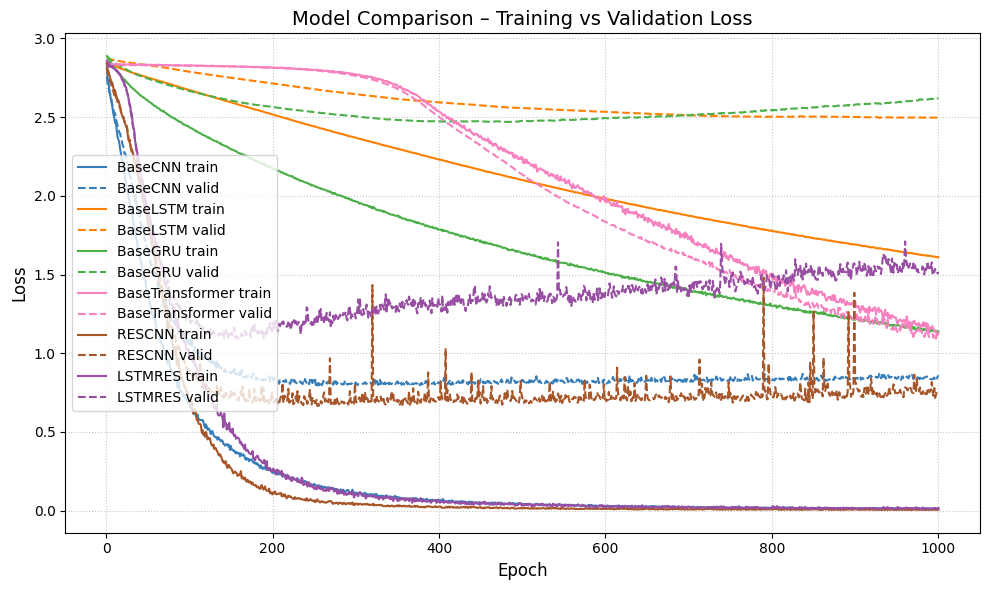

In [ ]:
models = {
    "BaseCNN":  BaseCNN(num_classes=len(mapg)),
    "BaseLSTM" : BaseLSTM(num_classes=len(mapg)),
    "BaseGRU" : BaseGRU(num_classes=len(mapg)),
    "BaseTransformer" : BaseTransformer(num_classes=len(mapg))
    ,
"RESCNN" : RESCNN(num_classes=len(mapg)).to(device)
,
"LSTMRES" : LSTMRES(num_classes=len(mapg))
,
"GRURES" :GRURES(num_classes=len(mapg))
}


histories = compare_models(
    models,
    train_loader,
    val_loader,
    criterion=nn.CrossEntropyLoss(),
    num_epochs=1000,
    device=device
)

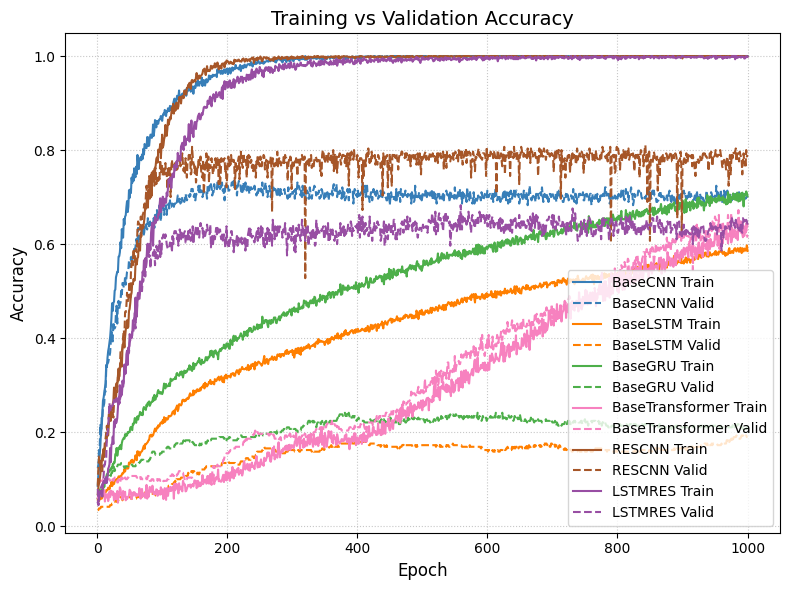

In [ ]:
def plot_accuracy(histories):
    """
    Plot training and validation accuracy for multiple models.

    Args:
        histories: dict
            {
              'ModelName': {
                  'train_acc': [float, ...],
                  'val_acc':   [float, ...]
              },
              ...
            }
    """
    num_epochs = len(next(iter(histories.values()))['train_acc'])
    epochs = range(1, num_epochs + 1)

    palette = ["#377eb8", "#ff7f00", "#4daf4a",
               "#f781bf", "#a65628", "#984ea3"]

    plt.figure(figsize=(8, 6))

    for (name, h), color in zip(histories.items(), palette):
        plt.plot(epochs, h['train_acc'],
                 label=f"{name} Train",
                 color=color, linestyle='-')
        plt.plot(epochs, h['val_acc'],
                 label=f"{name} Valid",
                 color=color, linestyle='--')

    plt.title("Training vs Validation Accuracy", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Accuracy", fontsize=12)
    plt.grid(linestyle=':', alpha=0.7)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

plot_accuracy(histories)

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset


def build_emg_images(df, feature_cols, label_col='label',
                     samples_per_gesture=4000,
                     segments=40):
    """
    df:           pandas DataFrame with columns feature_cols + label_col
    feature_cols: list of your 8 emg column names
    label_col:    name of your mapped integer label column
    samples_per_gesture: total samples in one gesture (here 4000)
    segments:     how many rows in your image (here 40)

    returns X_img: np.ndarray of shape (N, segments, samples_per_segment, C)
            y_img: np.ndarray of shape (N,)
    """
    seg_len = samples_per_gesture // segments  # here 100

    df = df.reset_index(drop=True)
    df['run_id'] = (df[label_col] != df[label_col].shift(1)).cumsum()

    X_img, y_img = [], []
    for (_, run_df), lbl in zip(df.groupby('run_id'), df.groupby('run_id')[label_col].first()):
        arr = run_df[feature_cols].values.astype(np.float32)  # shape (L, C)
        num_full = arr.shape[0] // samples_per_gesture
        for i in range(num_full):
            chunk = arr[i*samples_per_gesture : (i+1)*samples_per_gesture]
            # reshape → (segments, seg_len, C)
            img = chunk.reshape(segments, seg_len, len(feature_cols))
            X_img.append(img)
            y_img.append(lbl)

    X_img = np.stack(X_img)  # (N, 40, 100, 8)
    y_img = np.array(y_img, dtype=np.int64)
    return X_img, y_img

# usage:
features = [col for col in df.columns if 'emg' in col]
X3d, y3d = build_emg_images(df, features)

# 2) wrap in a Dataset
class EMGImageDataset(Dataset):
    def __init__(self, X, y):
        """
        X: np.array (N, H=40, W=100, C=8)
        y: np.array (N,)
        """
        self.X = torch.from_numpy(X)  # (N,40,100,8)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]              # (40,100,8)
        # permute to (C, H, W) for Conv2d:
        img = img.permute(3, 0, 1)     # (8,40,100)
        label = self.y[idx]
        return img, label


dataset = EMGImageDataset(X3d, y3d)
loader  = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
